In [1]:
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def get_images(line):
    """Returns centered, left and right images"""
    result = []
    for i in range(0, 3):
            source = line[i]
            filename = source.split('/')[-1]
            img_path = './data/IMG/%s' % filename
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            result.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            
    return result
    

lines = []
with open ('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

imgs = []
angles = []

for line in lines:
    angle = float(line[3])

    # Center
    center_source = line[0]
    center_fname = center_source.split('/')[-1]
    center_img_path = './data/IMG/%s' % center_fname
    center_img = cv2.imread(center_img_path, cv2.IMREAD_COLOR)
    center_img = cv2.cvtColor(center_img, cv2.COLOR_BGR2RGB)
    center_angle_correction = 0
    imgs.append(center_img)
    angles.append(angle)
    imgs.append(np.fliplr(center_img))
    angles.append(-angle)

    # Left
    left_source = line[1]
    left_fname = left_source.split('/')[-1]
    left_img_path = './data/IMG/%s' % left_fname
    left_img = cv2.imread(left_img_path, cv2.IMREAD_COLOR)
    left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
    left_angle_correction = angle + 0.2
    imgs.append(left_img)
    angles.append(left_angle_correction)
    imgs.append(np.fliplr(left_img))
    angles.append(-left_angle_correction)
    
    # Right
    right_source = line[2]
    right_fname = right_source.split('/')[-1]
    right_img_path = './data/IMG/%s' % right_fname
    right_img = cv2.imread(right_img_path, cv2.IMREAD_COLOR)
    right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)
    right_angle_correction = angle - 0.2
    imgs.append(right_img)
    angles.append(right_angle_correction)
    imgs.append(np.fliplr(right_img))
    angles.append(-right_angle_correction)
    

width = imgs[0].shape[1]
height = imgs[0].shape[0]
channels = imgs[0].shape[2]

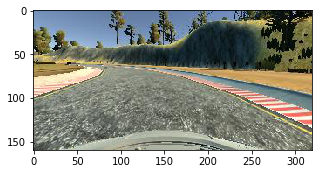

In [2]:
import numpy as np
X_train = np.asarray(imgs)
y_train = np.asarray(angles)

plt.figure(figsize=(5,5))
plt.imshow(X_train[0])

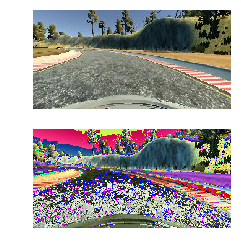

In [3]:
# Play with colors
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist
%matplotlib inline

sample_img = X_train[0]
new_img = ((sample_img / 127.6) - 1)


fig, ax = plt.subplots(nrows=2)
ax = ax.ravel()
ax[0].imshow(sample_img)
ax[1].imshow(new_img, cmap='gray')

for a in ax:
    a.axis('off')

In [48]:
def load_image(img_full_path):
    name = img_full_path.split('/')[-1]
    path = './data/IMG/%s' % name
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img,(200, 66))
    return img
    

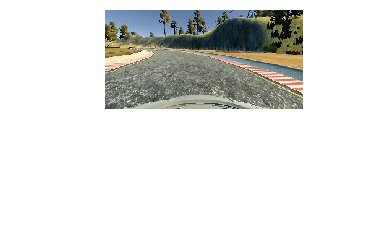

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_img = load_image(lines[0][0])

fig, ax = plt.subplots(nrows=2)
ax = ax.ravel()
ax[0].imshow(sample_img)

for a in ax:
    a.axis('off')

In [50]:
import sklearn.utils

CENTER = 0
LEFT = 1
RIGHT = 2
ANGLE = 3
LEFT_ANGLE_CORRECTION = 0.2
RIGHT_ANGLE_CORRECTION = -0.2

def generator(data, batch_size=128):
    num_samples = len(data)
    while True:
        data = sklearn.utils.shuffle(data)
        for offset in range(0, num_samples, batch_size):
            batch_samples = data[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:
                center_img = load_image(batch_sample[CENTER])
                left_img = load_image(batch_sample[LEFT])
                right_img = load_image(batch_sample[RIGHT])
                angle = float(batch_sample[ANGLE])
                
                images.append(center_img)
                angles.append(angle)
                
                images.append(left_img)
                angles.append(angle + LEFT_ANGLE_CORRECTION)
                
                images.append(right_img)
                angles.append(angle + RIGHT_ANGLE_CORRECTION)
            
            x_images = np.array(images)
            y_labels = np.array(angles)
            yield sklearn.utils.shuffle(x_images, y_labels)
        

In [51]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

In [55]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution2D
from keras.layers import Cropping2D, Lambda, Reshape
import tensorflow as tf

def resize(img):
    return tf.image.resize_images(img, (66, 200))

model = Sequential()
# Shave 50px from the top and 20px from the bottom to be left with a 90x320x img
model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=(160, 320, 3)))
#model.add(Lambda(lambda x: resize(x), input_shape=(160, 320, 3)))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu', name='conv1'))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu', name='conv2'))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu', name='conv3'))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv4'))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv5'))

model.add(Flatten())

model.summary()

#model.add(Dense(1164, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(loss='mse', optimizer='adam')
model.fit_generator(
    train_generator,
    samples_per_epoch=len(train_samples * 3),    # * 3 for center, left, and right image
    validation_data=validation_generator,
    nb_val_samples=len(validation_samples * 3),  # * 3 for center, left, and right image
    nb_epoch=5)

model.save('model.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_17 (Cropping2D)       (None, 90, 320, 3)    0           cropping2d_input_17[0][0]        
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 43, 158, 24)   1824        cropping2d_17[0][0]              
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 20, 77, 36)    21636       conv1[0][0]                      
____________________________________________________________________________________________________
conv3 (Convolution2D)            (None, 8, 37, 48)     43248       conv2[0][0]                      
___________________________________________________________________________________________

ResourceExhaustedError: OOM when allocating tensor with shape[384,43,158,24]
	 [[Node: gradients_16/Conv2D_101_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@Conv2D_101"], data_format="NHWC", padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](gradients_16/Conv2D_101_grad/Shape, conv2_W/read, gradients_16/add_1102_grad/Reshape)]]

Caused by op 'gradients_16/Conv2D_101_grad/Conv2DBackpropInput', defined at:
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-b05dfbdb790b>", line 36, in <module>
    nb_epoch=5)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py", line 935, in fit_generator
    initial_epoch=initial_epoch)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py", line 1450, in fit_generator
    self._make_train_function()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py", line 761, in _make_train_function
    self.total_loss)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/optimizers.py", line 411, in get_updates
    grads = self.get_gradients(loss, params)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/optimizers.py", line 80, in get_gradients
    grads = K.gradients(loss, params)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 1925, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 482, in gradients
    in_grads = grad_fn(op, *out_grads)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/nn_grad.py", line 342, in _Conv2DGrad
    op.get_attr("data_format")),
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 489, in conv2d_backprop_input
    data_format=data_format, name=name)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

...which was originally created as op 'Conv2D_101', defined at:
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-b05dfbdb790b>", line 15, in <module>
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu', name='conv2'))
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py", line 332, in add
    output_tensor = layer(self.outputs[0])
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/topology.py", line 572, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/topology.py", line 635, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/topology.py", line 166, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/layers/convolutional.py", line 475, in call
    filter_shape=self.W_shape)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 2627, in conv2d
    x = tf.nn.conv2d(x, kernel, strides, padding=padding)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[384,43,158,24]
	 [[Node: gradients_16/Conv2D_101_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@Conv2D_101"], data_format="NHWC", padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](gradients_16/Conv2D_101_grad/Shape, conv2_W/read, gradients_16/add_1102_grad/Reshape)]]
